In [1]:
import pandas as pd
import numpy
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import cycle, islice
import pylab as pl
import torch
from torch.distributions import Categorical, Beta, Dirichlet, Uniform
from torch.distributions import MultivariateNormal as Normal
from IPython import display
import time
from pylab import rcParams
from helpers import *
sns.set()

<div class="alert alert-block alert-info">

# Bayesian nonparametrics: An introduction to the Dirichlet Process
</div>

<div class="alert alert-block alert-info">
<h3>The goal of this tutorial:</h3>
    
- To introduce BNPs to an audience with more of a computer science / ML background than a statistics one.
- See Tamara Brodrick's tutorial <a href=http://www.tamarabroderick.com/tutorial_2016_mlss_cadiz.html> here</a> for a more comprehensive introduction to BNPs
    - I pretty much just jupyter-ified her first lecture. 
    - I won't discuss inference in this tutorial but see her part 2 / 3 
- I'll focus on intuition over detailed mathematical precision.

<h3>The plan:</h3>

- First we're going to start with <b>non-Bayesian, parametric </b> statistics, then go to <b>Bayesian, parametric </b> statistics, then finally arrive at <b>Bayesian, non-parametric </b> statistics, hopefully building intuition throughout.
</div>

<div class="alert alert-block alert-success">
 <h1> The non-Bayesian approach </h1>
    <br>


<h3>The toy problem:</h3>

- To guide us, we're going to begin with a humble little 2-component Gaussian Mixture Model with fixed covariance
    - If you haven't seen GMMs before, cf. Chris Bishop's excellent textbook _Pattern Recognition and Machine Learning_, sections 2.3.9 and 9.2
- We'll make the problem more complicated as we go, eventually leading up to Bayesian non-parametrics.

</div>

### 2-component gaussian mixture model

K = 2 clusters.
$$ \begin{align}
        & z_i \sim Categorical(\rho_0, \rho_1) && i \in \{1..N\}\\
        & x_i \sim \mathcal{N}(\mu_{z_i}, I)
    \end{align}
$$


-  To generate a datapoint $x_i$, we first sample a cluster $z_i \in \{0, 1\}$, then we sample from a gaussian with mean $\mu_{z_i}$
- $\rho_0, \rho_1$ specify the probability of sampling cluster $z_0, z_1$, respectively.

- To be a valid probability distribution, $\rho_0, \rho_1$ must sum to one.
- We want to learn $\rho_0, \rho_1, \mu_0, \mu_1$
            
Now lets play god and imagine how he generated the data.

<div class="alert alert-block alert-warning">
 <h3> Note: </h3>
 
Set the 'animate' flag to True to watch how the data is generated. Note however, generating all the data takes a long while, so after you get the point I suggest killing the cell and re-generating without animation. 
</div>

In [7]:
##############################
##### NATURE'S PARAMETERS ####
##############################
p0_true, p1_true = 0.1, 0.9 ## <---- We're going to try to learn these
mu0_true = parameter(2, 3)  ## <---- We're going to try to learn these
mu1_true = parameter(7, 8)  ## <---- We're going to try to learn these
##############################
##############################


def run_non_bayes_parametric(animate=False):
    # God-given parameters 

    measure = parameter(p0_true, p1_true)
    mu = [mu0_true, mu1_true]

    observations_from_the_real_world = []

    # How we imagine the data is created 
    for i in range(1000):

        # We will randomly draw Z==0 with probability p1 
        # and Z==1 with probability p2
        z = Categorical(measure).sample()

        # Then sample from mu_z
        datum = Normal(mu[z], torch.eye(2)).sample().numpy()

        # Save data
        observations_from_the_real_world += [(datum[0], datum[1], int(z))]    

        # Animate
        if animate:
            plot(observations_from_the_real_world, mu, z)
            display.clear_output(wait=True)
            display.display(pl.gcf())

    display.clear_output(wait=True)
    plot(observations_from_the_real_world, mu)
    return observations_from_the_real_world

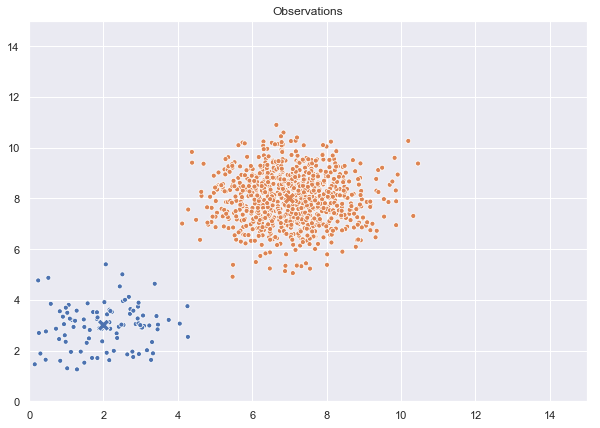

In [26]:
observations = run_non_bayes_parametric(animate=False)


    
#### Of course, we only see the end result:

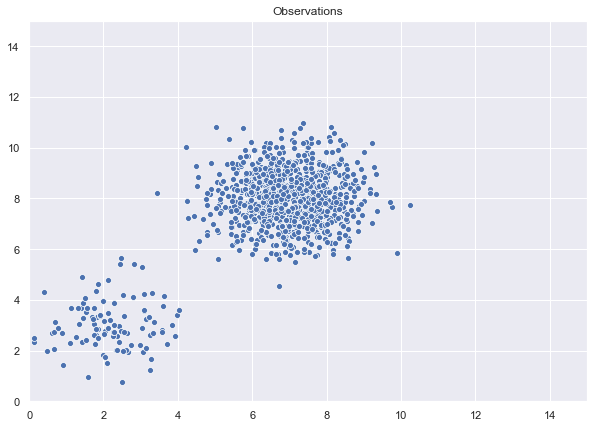

In [9]:
plot(observations)

To perform inference in this setting, we would use K-Means to find the cluster centers $\hat{\mu}_0, \hat{\mu}_1$ and count how many data points appear in each cluster to compute. $\hat{\rho}_0, \hat{\rho}_1$. 

In [10]:
inferred_params = kmeans(observations)
mu0_hat, mu1_hat, p0_hat, p1_hat = inferred_params

# May kmeans might swap the labels of the clusters
print("Nature's parameters:")
print("--------------------")
print("mu0: {}, p0: {}".format(mu0_true, p0_true))
print("mu1: {}, p1: {}".format(mu1_true, p1_true))
print("\n")
print("Learned parameters (may swap label names):")
print("--------------------")
print("Learned mu0: {}, p0: {}".format(mu0_hat, p0_hat))
print("Learned mu1: {}, p1: {}".format(mu1_hat, p1_hat))



Nature's parameters:
--------------------
mu0: tensor([2., 3.]), p0: 0.1
mu1: tensor([7., 8.]), p1: 0.9


Learned parameters (may swap label names):
--------------------
Learned mu0: [6.981377 8.024071], p0: 0.893
Learned mu1: [2.067102  3.0426335], p1: 0.107


<div class="alert alert-block alert-success">
    
# Now, same problem, but taking a Bayesian approach
</div>

<h3> First, what does it mean to "be Bayesian"? </h3>
    
- Once upon a time, there was an argument about what "probability" actually means. "Frequentists" said probability was about the long-term frequency of reoccuring events, and "Bayesians" said probability was about subjective beliefs.
    - For example, what does it mean to say "There is a 90% chance the polar ice caps will melt in 2100?" from a frequentist perspective? 
    - Lots of controversy, debate, and confusion about what it means to be "Bayesian". Strongly recommend reading Bishop section 1.2.3 
- Nowadays, Bayesians switch between both interpretations, but it's often useful to think of "computing the posterior" as "updating our prior beliefs based on new evidence".
- Practically speaking, "to be Bayesian" means we are often interested in computing <b>distributions</b> over parameters rather than just single point values (as we did above).
- Why? Because we're <b>now using probability distributions to capture our certainty about what the true parameter values are</b>.


<h3> Lets see what this looks like:</h3>


$$ \begin{align}
    & \rho_0, \rho_1 \sim Dirichlet(a_0, a_1) \\
    & \mu_{k} \sim \mathcal{N}(\mu_0, \Sigma_0) && k \in \{1 .. 2\}\\
    & z_i \sim Categorical(\rho_0, \rho_1) && i \in \{1 .. N\}\\
    & x_i \sim \mathcal{N}(\mu_{z_n}, I)\\
    \end{align}
$$


Our four parameters $\rho_0, \rho_1, \mu_0, \mu_1$ <b> have now become random variables </b>.
$a_0, a_1, \mu_0, \Sigma_0$ are new parameters that allow us to specify our prior beliefs about what $\rho_0, \rho_1, \mu_0, \mu_1$ are before we see the data.

Why use a Dirichlet? Remember $\rho_0, \rho_1$ are themselves probabilities that specify the categorical distribution. Therefore whatever values of $\rho_0, \rho_1$ we sample must sum to one. The Dirichlet does just this. It can be thought of as a "distribution over distributions", because whatever we sample can be used as a valid probability distribution. Because they are probabilities they must sum to one, and we can represent them like this:

<div class="alert alert-block alert-warning">
 <h3> Note: </h3>
 
Play with the 'rate' parameter to see how it affects the stick lengths. Do you understand why p0, p1 must sum to one? 

</div>

p0:  tensor(0.8908)
p1:  tensor(0.1092)


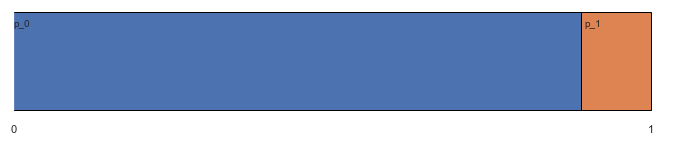

In [45]:
rate = 1
p0, p1 = Dirichlet(parameter(rate, rate)).sample()
print("p0: ", p0)
print("p1: ", p1)
plot_stick(parameter(p0, p1))

In [1]:
def run_bayes_parametric(animate=False):
    # We're now thinking about probabilities in the bayesian sense,
    # so a0, a1 represent our prior beliefs about what p0, p1
    # might be before we see any of the data
    
    # a0 and a1 can be thought of as the pseudo-observations in our prior belief.
    # You can therefore have e.g. a0 = 100, a1 = 50, which would correspond
    # to a prior belief on the probabilities of a0/(a0+a1) = 100/150 and a1/(a0+a1) = 50/150.
    # Our confidence in these probabilities are expressed as (a0+a1) = 150.
    # a0, a1 = 0.5, 0.5 thus corresponds to a prior belief of 0.5, 0.5 but with a low confidence.
    
    a0, a1 = 0.5, 0.5

    # mu0, sig0 represent our prior beliefs about where we think the clusters are located.
    # mu0 says: "this is where I think they clusters are likely to be"
    # sig0 says: "And this is how confident I am about that."
    mu0, sig0 = parameter(5,5), parameter([5,0],
                                          [0,5])

    # Now p0, p1 are *themselves* random variables
    # which define a probability measure over the space of Z
    # (Therefore the Dirichlet is a 'distribution over distributions')
    measure = Dirichlet(parameter(a0, a1)).sample()
    p0, p1 = measure

    # mu1 and mu1 are also now random variables
    mu1 = Normal(mu0, sig0).sample()
    mu2 = Normal(mu0, sig0).sample()

    # ---------------------------------------
    #  Everything below is the same as before
    # ---------------------------------------

    mu = [mu1, mu2]

    observations_from_the_real_world = []

    # How we imagine the data is created 
    for i in range(1000):

        # We will randomly draw Z==0 with probability p0 
        # and Z==1 with probability p1
        z = Categorical(torch.tensor([p0, p1])).sample()

        # Then sample from mu_z
        datum = Normal(mu[z], torch.eye(2)).sample().numpy()

        # Save data
        observations_from_the_real_world += [(datum[0], datum[1], int(z))]    

        # Animate
        if animate:
            plot(observations_from_the_real_world, mu, z)
            display.clear_output(wait=True)
            display.display(pl.gcf())

    display.clear_output(wait=True)
    plot(observations_from_the_real_world, mu)

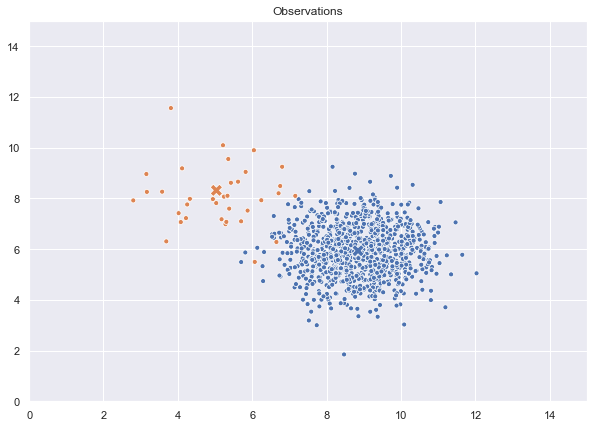

In [52]:
observations = run_bayes_parametric(animate=False)

#### Now the clusters change every time we recreate the data.

<div class="alert alert-block alert-success"> 

### At this point, if we were doing regular bayesian parametric inference...</h3>

</div>

We would discuss the many, many ways to learn an approximation to the posterior:

$$
P(\theta | X_{1..N}) \propto P(X_{1..N} | \theta)P(\theta)\\
\theta = \{\mu_1, \mu_2, \rho_1, \rho_2\}
$$

The posterior represents our updated beliefs about what the parameter values are after we see evidence from the world. For example, we could:

- Make conjugacy assumptions so computing the posterior is easy
- Use approximate inference techniques like variational inference or MCMC
- Use probabilistic programming languages like Pyro, PyProb, Edward, etc. to compute it automatically

These are all _parametric bayes_, because we're computing a posterior over a fixed number of parameters. We're going to do something different.

<div class="alert alert-block alert-success"> 
    
### To lead us to bayesian non-parametrics, let's start with a question: Would it ever make sense to have more clusters K than datapoints N? 

</div>

Imagine Darwin collecting samples of species on the Galpagos Islands. It's reasonable to assume there are more extant species on the island than are present in his samples. It's useful to make a distinction between _components_ and _clusters_:

- __Components__ are the number of extant species on the island
- __Clusters__ are the number of species present in the data.

Or more generally:

- __Components__ are the latent groups $p_1, p_2, ... p_K$
- __Clusters__ are the componenets present in the data.

There reason we make this distinction is that although it doesn't make sense to have more _clusters_ than datapoints, we can have more _components_ than data points. We expect that as we collect more and more data, the number of clusters we see in our data will approach the true number of latent components. 
#### How might we do this?

Recall the Dirichlet distribution, where we use the samples $\rho_0, \rho_1 \sim Dirichlet(a_0, a_1)$ as probabilities for the categorical distribution:

$$
\begin{align}
    & \rho_0, \rho_1 \sim Dirichlet(a_0, a_1) \\
    & z_i \sim Categorical(\rho_0, \rho_1) \\
\end{align}
$$

We can think of $\rho_0, \rho_1$ as pieces of a probability "stick" that we've broken into K=2 component. The length of the piece of stick represents the probability of sampling from that component. If K is greater than 2 it looks like this:

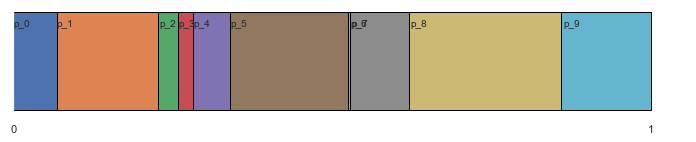

In [53]:
rate = 1.0
K = 10
measure = Dirichlet(parameter(*[rate for i in range(K)])).sample()
plot_stick(measure)

In other words, we think about sampling from the Dirichlet distribution as <b>breaking the unit-length probability stick into K pieces.</b> This visualization gives us a new way to generate the data that will be useful when we finally set K = $\infty$:

- First, break the stick into K components.
- Then, for each datapoint 1..N:
    - sample from the uniform distribution and see which component we land in.
    - If we land in a new component:
        - Make a new cluster
    - Sample from the cluster 

In [54]:
def run_bayes_parametric_stick_view(animate=False):
    K = 200
    rate = 0.05

    # Now we consider the measure to be 'components'
    components = Dirichlet(parameter(*[rate for i in range(K)])).sample()
    stick = pd.DataFrame(np.append(0, components.cumsum(0)))

    # And 'clusters' to be those components we sample via the stick breaking process
    component_to_mean_map = {}

    mu0, sig0 = parameter(5,5), parameter([5,0],
                                          [0,5])

    observations_from_the_real_world = []

    for i in range(1000):

        # We will randomly draw from the uniform 
        # to see where we land on the stick

        u = Uniform(0, 1).sample().numpy()
        component = int(stick.where(stick < u).idxmax())

        if component in component_to_mean_map.keys():
            mu = component_to_mean_map[component]
        else:
            mu = Normal(mu0, sig0).sample()
            component_to_mean_map[component] = mu

        # Then sample from mu_z
        datum = Normal(mu, torch.eye(2)).sample().numpy()

        # Save data
        observations_from_the_real_world += [(datum[0], datum[1], component)]

        if animate:
            time.sleep(1.0)
            plot_stick_and_data(observations_from_the_real_world,
                                components,
                                component_to_mean_map,
                                arrow=float(u))

            display.clear_output(wait=True)
            display.display(pl.gcf())

    display.clear_output(wait=True)
    plot_stick_and_data(observations_from_the_real_world,
                        components,
                        component_to_mean_map)

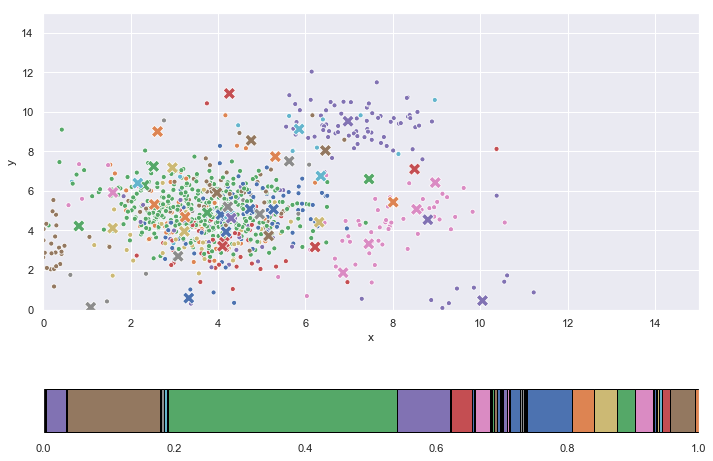

In [55]:
run_bayes_parametric_stick_view(animate=False)

So now we see clusters are 'made on demand' from a higher dimensional component-space. We draw a uniform value between zero and one and see which of the K components we land in. If we haven't landed there before we create a new cluster, which can be thought of an 'instantiated component', and then sample from it. 

The important point to realize is that although we can't have more _clusters_ than data points, we can have more _components_ than data points. We can think of "components" as those groups present in the true population, while "clusters" are those groups that appear in our sample. 

<div class="alert alert-block alert-success">
    
# And finally, a bayesian non-parametrics approach.

</div>

However, we are limited by K. If we collect enough data, eventually we'll discover all the components in the data. What does it mean to be non-parametric? It's means we want to come up with a data-generating process that has an _infinite_ number of components. That way, as we continue to collect more and more data, the number of components the data is generated from _also_ grows and doesn't hit some ceiling fixed at K. 

How could we set K to be $\infty$? By breaking off pieces of the stick as we need them, rather than all at once. For intuition, think about Zeno's ~~paradox~~ misunderstanding before we had calculus. To travel a distance between point $a$ and $b$ we must first travel half that distance, and half of that, and half of that...

We are going to break the unit-length probability stick in "half", then break the remaining piece in "half", ad infinitium. In this manner we can break the unit probability stick into an infinite number of components. Let's formalize this.

Consider the Dirichlet distribution with two components, parameterized by a single value $\alpha$:

$$
V_1, (1 - V_1) \sim Dirichlet(1, \alpha)
$$

This breaks the unit probability stick into two pieces:

In [ ]:
alpha = 4
V1, _ = Dirichlet(parameter(1, alpha)).sample()
plot_stick(parameter(V1, 1 - V1), labels=["V1", "1 - V1"])

We set the first component equal to $V_1$ and split the remaining stick in two pieces as follows:

$$
\begin{align}
&V_1, (1 - V_1) \sim Dirichlet(1, \alpha) && \rho_1 = V_1 \\
&V_2, (1 - V_2) \sim Dirichlet(1, \alpha) && \rho_2 = (1 - V_1)V_2
\end{align}
$$

After the first division, we have $(1 - V_1)$ of the stick left. We want exactly $V_2$ of the remaining $(1 - V_1)$. Therefore the second component $\rho_2 = (1 - V_1)V_2$. 

In [ ]:
alpha = 4
V1, _ = Dirichlet(parameter(1, alpha)).sample()
V2, _ = Dirichlet(parameter(1, alpha)).sample()

p1 = V1
p2 = (1 - V1)*V2

plot_stick(parameter(p1, p2, 1 - p1 - p2 ), labels=["p1", "p2", "1 - p1 - p2"])

And again...
$$
\begin{align}
&V_1, (1 - V_1) \sim Dirichlet(1, \alpha) && \rho_1 = V_1 \\
&V_2, (1 - V_2) \sim Dirichlet(1, \alpha) && \rho_2 = (1 - V_1)V_2 \\
&V_3, (1 - V_3) \sim Dirichlet(1, \alpha) && \rho_3 = (1 - V_1)(1 - V_2)V_3
\end{align}
$$


In [ ]:
alpha = 4
V1, _ = Dirichlet(parameter(1, alpha)).sample()
V2, _ = Dirichlet(parameter(1, alpha)).sample()
V3, _ = Dirichlet(parameter(1, alpha)).sample()

p1 = V1
p2 = (1 - V1)*V2
p3 = (1 - V1)*(1 - V2)*V3

plot_stick(parameter(p1, p2, p3, 1 - p1 - p2 - p3 ), labels=["p1", "p2", "p3", "1 - p1 - p2 - p3"])

If we never stop, this is known as the "Griffiths-Engen-McCloskey" (GEM) distribution:

$$
\rho = (\rho_1, \rho_2, ...) \sim GEM(\alpha)\\
V_k \overset{\text{i.i.d}}{\sim} Beta(1, \alpha) \\
\rho_k = \prod_{j_1}^{k - 1} (1 - V_j)(V_k)
$$

Where we have used the $Beta(1, \alpha)$ in place of the $Dirichlet(1, \alpha)$. The Dirichlet is simply the Beta distribution generalized to $K \ge 2$ dimensions. In fact:

- Beta $\rightarrow$ Random distribution over 0, 1
- Dirichlet $\rightarrow$ Random distribution over 0, 1, ..., K
- GEM $\rightarrow$ Random distribution over 0, 1, ...  $\infty$


We want to use the GEM in place of the Dirichlet in our mixture model example. However, we don't want to create an infinite number of parameters in advance. Is this doable? Yes! We'll simply draw a uniform sample _first_, then use the stick-breaking process to generate just enough components to get us to the other side of the uniform draw:

In [27]:
# We'll use a closure to keep track of the components that were previously generated
def GEM(alpha):
    rhosum = 0
    components = []
    def _gem(uniform):
        nonlocal rhosum, components
        if uniform < 0 or uniform > 1:
            raise ValueError("Uniform must be between 0 and 1")
        while rhosum < float(uniform):
            V = Beta(parameter(1), parameter(alpha)).sample()
            newrho = (1 - rhosum)*V
            components += [newrho]
            rhosum += newrho
        return parameter(components).squeeze()
    return _gem

In [28]:
def run_bayes_non_parametric(animate=False):
    alpha = 4.0

    gem = GEM(alpha)

    # And 'clusters' to be those components we sample via the stick breaking process
    component_to_mean_map = {}

    # Base distribution N(u_0, sig_0), from which we will
    # draw the means for each component
    mu0, sig0 = parameter(5,5), parameter([5,0],
                                          [0,5])

    observations_from_the_real_world = []

    for i in range(1000):

        # We will randomly draw from the uniform 
        # to see where we land on the stick

        u = Uniform(0, 1).sample().numpy()
        
        # Now generate as many components as we need to cover the uniform draw
        components = gem(u)
        stick = pd.DataFrame(np.append(0, components.cumsum(0)))
    
        component = int(stick.where(stick < u).idxmax())
        if component in component_to_mean_map.keys():
            mu = component_to_mean_map[component]
        else:
            mu = Normal(mu0, sig0).sample()
            component_to_mean_map[component] = mu

        # Then sample from mu_z
        datum = Normal(mu, torch.eye(2)).sample().numpy()

        # Save data
        observations_from_the_real_world += [(datum[0], datum[1], component)]

        if animate:
            time.sleep(1.0)
            plot_stick_and_data(observations_from_the_real_world,
                                components,
                                component_to_mean_map,
                                arrow=float(u))

            display.clear_output(wait=True)
            display.display(pl.gcf())

    display.clear_output(wait=True)
    plot_stick_and_data(observations_from_the_real_world,
                        components,
                        component_to_mean_map)

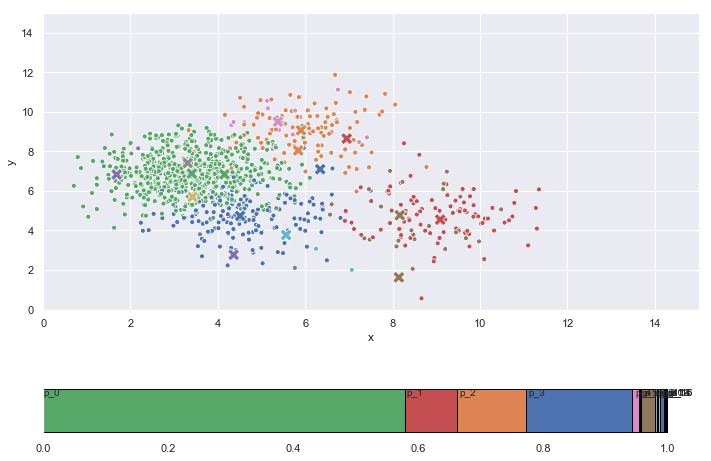

In [31]:
run_bayes_non_parametric(animate=False)

This is known as a "Dirichlet Process Mixture Model."

$$
\rho_0, \rho_1, ... \sim GEM(\alpha) \\
\mu_0, \mu_1, ... \overset{\text{i.i.d}}{\sim} \mathcal{N}(\mu_0, \Sigma_0)\\
$$

Let's summarize what we've done. We sample an infinity of mixing proportions $\rho_0, \rho_1, ... \sim GEM(\alpha)$, where $\rho_k$ specifies the probability of each component $k$. Then we generate an infinity of means $\mu_0, \mu_1, ... \overset{\text{i.i.d}}{\sim} \mathcal{N}(\mu_0, \Sigma_0)$ from some base distribution $\mathcal{N}(\mu_0, \Sigma_0)$. Finally, we associate each proportion $\rho_k$ with each mean $\mu_k$. 

This can be summarized as follows:

$$
G = \sum_{k=1}^{\infty}\rho_k \delta_{\mu_k} \triangleq DP(\alpha, \mathcal{N}(\mu_0, \Sigma_0))
$$

This procedure specifies a _Dirichlet Process_ $DP(\alpha, G_0)$, where $\alpha$ is a positive scaling parameter which specifies the "length" of each stick we break off, and $G_0$ is a base distribution over some space $\Phi$. When we use a standard normal $G_0 = \mathcal{N}(\mu_0, \Sigma_0)$ we get a _Dirichlet Process Mixture Model_. We can therefore specify the model under a non-parametric Dirichlet Process prior as follows:

$$
G_0 = \mathcal{N}(\mu_0, \Sigma_0) \\
G \sim DP(\alpha, G_0)\\
X_1, X_2,~... | ~ G \sim G 
$$


<div class="alert alert-block alert-success">
    
# What's next?

</div>

The goal of this tutorial was to introduce the topic of bayesian non-parametrics to non-statisticans. We have specified the generative process under a Dirichlet Process prior, but the big missing piece is: _How do we perform inference under a DP prior?_ This requires we introduce concepts like "The Chinese Restaurant Process", "Gibbs Sampling", "Exchangablity", and "de Finetti's theorem", all of which are outside of the scope of this tutorial. Interested readers are encouraged to check out the following resources for a more comprehesive and detailed introduction to bayesian non-parametrics:

- Tamara Brodrick's three-part Non Parametric Bayes tutorial:
    - http://www.tamarabroderick.com/tutorial_2016_mlss_cadiz.html
    - Part 1 was my primary resource for this introduction
    - Parts 2 and 3 discuss inference and applications
- Mike Jordan's 2005 NIPS tutorial slides:
    - https://www.cs.princeton.edu/courses/archive/fall07/cos597C/readings/Jordan2005.ps
- Zoubin Ghahramani's UAI tutorial
    - https://www.cs.princeton.edu/courses/archive/fall07/cos597C/syllabus.html
    
Please email Vaden at vadmas@cs.ubc.ca if you spot errors or have any suggestions for improvement. Many thanks to Didrik Nielsen at DTU for his helpful feedback.
